This notebook is aimed at doing some genome analysis in terms of location of certain elements and their relational localization.


This notebook was only designed for the purpose of analyzing the Pst-104E genome and is now adpated to work for DK0911_v4. No gurantees it works in any other situtation. It will have spelling errors due to the lack of autocorrection.

The local output folder is /home/benjamin/genome_assembly/Warrior/DK0911_v04/effector_candidate_analysis

In [1]:
%matplotlib inline

In [42]:
import os
from Bio import SeqIO
import pandas as pd
import re
from pybedtools import BedTool
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import scipy.stats
import statsmodels.sandbox.stats.multicomp
#import rcParams and make it outfit also when saving files
from matplotlib import rcParams
import scipy.stats as stats
rcParams.update({'figure.autolayout': True})

In [3]:
#define your input folders
#define your input folders updated for haplotigs
EFFECTORP_FOLDER = '/home/benjamin/genome_assembly/Warrior/DK0911_v04/comp_orthology/DK0911_annotations'
GFF_FOLDER = '/home/benjamin/genome_assembly/Warrior/DK0911_v04/comp_orthology/DK0911_annotations'
PROTEIN_ANNO_FOLDER = '/home/benjamin/genome_assembly/Warrior/DK0911_v04/protein_annotation/DK_0911_v04LT_p_ctg/combined'
OUT_FOLDER = '/home/benjamin/genome_assembly/Warrior/DK0911_v04/effector_candidate_analysis'
OUT_FOLDER_FIG = os.path.join(OUT_FOLDER, 'figures')
TMP_FIG_PATH = os.path.join(OUT_FOLDER, 'tmp_figures')

In [4]:
for folder in [OUT_FOLDER_FIG,TMP_FIG_PATH]:
    if not os.path.exists(folder):
        os.mkdir(folder)

In [5]:
###make a function out of the 5' and 3' prime distance
def _5_to_3_df(ref_bed_fn, query_bed_fn, io=False ):
    """Takes two bed6 filenames and returns dataframe with 5' and 3' distances."""
    from pybedtools import BedTool
    ref = BedTool(ref_bed_fn)
    query = BedTool(query_bed_fn)

    sub_3 = ref.closest(query ,io=io,  N=True, iu=True, D='a' ).to_dataframe()
    sub_3.rename(columns={12:'3_distance', 3:'query', 9:'3_target', 0:'contig'}, \
                 inplace=True)
    sub_5 = ref.closest(query,\
                                io=io,N=True, id=True, D='a' ).to_dataframe()
    sub_5.rename(columns={12:'5_distance', 3:'query', 9:'5_target', 0:'contig'}, inplace=True)

    #merging them
    sub_merged = sub_3.merge(sub_5, on=['query', 'contig'])

    #needs to be fixed to take boundaries into account
    #remove genes on the edges
    sub_merged = sub_merged [((sub_merged['5_target'] != '.') & (sub_merged['3_target'] != '.') )  ]
    sub_merged['5_distance'] = sub_merged['5_distance'].apply(lambda x: np.absolute(x))
    return sub_merged

In [6]:
#makeing a function out of 5' and 3' distance bining
def _5_to_3_chains(_5_prime_df, _3_prime_df, max_distance=15000, label=''):
    """This function takes two dataframes one from _5_prime_ nearest neighbour and one from
    _3_prime_nearest neighbour. max_distance and label for the df columns can be added as well.
    Those should be generated with pybedtools and converted to dataframe
    without subsetting and with selecting the distance.
    Columns should be renamed as
    12:'3_distance', 3:'query', 9:'3_target', 0:'contig' for _3_prime
    and
    12:'5_distance', 3:'query', 9:'5_target', 0:'contig' for _5_prime
    The output will be new dataframe that contains the merged dataframes, the linked information, the linkage group,
    and the frequency of each linkage group = group member count.
    And a dataframe that summarizes the bin size, number within each bin and number of each bin.
    member_count_label	bin_size_label	number_of_bins_label
    """
    five_df = _5_prime_df.copy()
    three_df = _3_prime_df.copy()
    max_distance = max_distance
    
    #getting 5' and 3' distance
    distance_df = three_df.merge(five_df, on = ['query','contig'])

    #convert negative -1 from bedtools closest to nan and make values absolute
    tmp_index = distance_df[distance_df['5_target'] == '.'].index
    distance_df.loc[tmp_index, '5_distance'] = np.nan
    distance_df['5_distance'] = abs(distance_df['5_distance'])
    distance_df['5_distance'].fillna(-1, inplace = True) 
    #convert -1 from bedtools closest to nan in 3_distance
    tmp_index = distance_df[distance_df['3_target'] == '.'].index
    distance_df.loc[tmp_index, '3_distance'] = -1

    #subset the df and get the index first by distance and than by linkage (remember everything at the edges got a  -1 as distance)
    sub_distance_df = distance_df[\
                            ((distance_df['3_distance'] <max_distance)&(distance_df['3_distance'] > - 1)) \
                                           | 
                            ((distance_df['5_distance'] <max_distance) &(distance_df['5_distance'] > -1))  ]

    #get the max distance of two consective genes in teh distance_df. It could be to have A-B close and C-D close but not B-C currently
    #this would not have gotten caught. #to be illustrated

    sub_distance_df['next_distance'] = abs(sub_distance_df.shift(-1)['1_x'] - sub_distance_df['2_x'])

    #now set the distance to the next gene to max_distance +1 if the next contig is different
    #from the current one
    next_contig_index = sub_distance_df[sub_distance_df.shift(-1)['contig'] != sub_distance_df['contig']].index.values

    sub_distance_df.loc[next_contig_index, 'next_distance'] = max_distance +1

    #get the index values and not the series
    sub_distance_df_index = sub_distance_df.index.values

    #transfer the next_distance of the linked once the main datframe and make everything else max_distance +1

    distance_df['next_linked_distance'] = max_distance +1

    distance_df.loc[sub_distance_df_index, 'next_linked_distance'] = sub_distance_df.next_distance


    #introduce new column 'linked' and make this 1 were the genes are linked (e.g. less than max distance apart)
    distance_df['linked'] =0
    distance_df.loc[sub_distance_df_index, 'linked']  = 1
    #get a new columns linkage_group that is 0 for now
    distance_df['linkage_group'] = 0

    #get linkage groups first filtered by consecutive index
    tmp_linkage_groups = ((distance_df[distance_df.linked == 1].linked \
                          != distance_df[distance_df.linked == 1].linked.index.to_series().diff().eq(1))).cumsum()\
    
    #this also adds together genes that are not really linked because they are on a different contig or A-B close and
    #C-D close but not B-C. We need to take care of this later on using the next_linked_distance column
    distance_df.loc[distance_df[distance_df.linked == 1].index, 'tmp_lg']  = tmp_linkage_groups
    
    #generate a new sub_distance_df that has all colmuns as the main distance df
    sub_distance_df = distance_df[distance_df.linked == 1]
    
    #the indexes are consectutive as indicated by the tmp linkage_group. 
    #now identify where linked sequences are separated by more than the max_distance. This includes intercontigs breaks.
    
    unlinked_lg_index = (sub_distance_df[(sub_distance_df.tmp_lg.shift(-1) == sub_distance_df.tmp_lg)]\
                                                  ['next_linked_distance'] > max_distance)
    
    #combine this remove unlinked_lg_indexs from initial linkage group by making everything Flase that is not linked.
    #this requires to 'add' the unlinked_lg_index boolean array to the consecutive boolean array using an or |
    #meaning only the Trues are transfered and this needs to be shiffted one downward (could have also done previous distance and not
    #next)
    
    tmp_linkage_groups = ((distance_df[distance_df.linked == 1].linked \
                          != distance_df[distance_df.linked == 1].linked.index.to_series().diff().eq(1))\
    | unlinked_lg_index.shift(1)).cumsum()
    
    distance_df.loc[distance_df[distance_df.linked == 1].index, 'linkage_group']  = tmp_linkage_groups
    
    distance_df = distance_df.loc[:,['contig', 'query', '3_target',\
                                            '3_distance', '5_target', '5_distance', 'linked', 'linkage_group']]
    #add a frequency columns to the dataframe
    distance_df['lg_freq'] = distance_df.groupby('linkage_group')['linkage_group'].transform('count')
    
    #now make a bin count dataframe
    
    #get the counts for each lg_freq == total number of genes in a bin of size lg_freq
    bins = distance_df[distance_df.linked !=0 ].groupby('lg_freq').count()
    
    #now get unlinked total number of genes ina bin size of 1
    bin_one = distance_df[distance_df.linked ==0 ].groupby('lg_freq').count().reset_index(drop= True)

    bin_one.index = [1] 
    #combine both
    all_bins = bins.append(bin_one)
    #use the index which represents the bin size
    all_bins['bin_size'] = all_bins.index
    
    all_bins = all_bins.sort_values('bin_size').reset_index(drop=True).loc[:, ['linked', 'bin_size']]

    all_bins.rename(columns={'linked': 'member_count'}, inplace=True)

    all_bins['number_of_bins'] = all_bins['member_count'] / all_bins['bin_size']

    #new_cnames = ['%s_%s' % (x,label) for x in all_bins.columns]

    #all_bins.rename(columns=dict(zip(all_bins.columns, new_cnames)), inplace=True)
    
    all_bins['label'] = label
    
    #all_bins['bin_size'] = all_bins['bin_size_' + label]
    return distance_df, all_bins

In [7]:
#define a function that subsets a dataframe to the inner quantil residual columnwise
def quant_cut_df(dataframe):
    nn_df = dataframe.copy()
    iqr_df_low = nn_df.apply(lambda x: x.quantile(0.25) - 1.5*(x.quantile(0.75) - x.quantile(0.25)) )
    iqr_df_low.name ='low'
    iqr_df_high = nn_df.apply(lambda x: x.quantile(0.75) + 1.5*(x.quantile(0.75) - x.quantile(0.25)) )
    iqr_df_high.name = 'high'

    iqr_df = pd.concat([iqr_df_low, iqr_df_high], axis=1).T

    iqr_nn_df = nn_df.apply(lambda x: x[(x > iqr_df.loc['low', x.name]) & (x  < iqr_df.loc['high', x.name])], axis=0)
    return iqr_nn_df 


In [8]:
def filter_bed_files(in_bed_six_fn, out_bed_six_fn, tb_removed):
    in_df = pd.read_csv(in_bed_six_fn, header=None, sep='\t')
    out_df = in_df[~in_df[3].isin(tb_removed)]
    out_df.to_csv(out_bed_six_fn, header = None, index=None, sep='\t')

In [9]:
def sort_bed_files(bed_fn):
    bed_df = pd.read_csv(bed_fn, header=None, sep='\t')
    bed_df.sort_values(by=[0, 1]).to_csv(bed_fn, header=None, index=None, sep='\t')

In [10]:
#get some empty list to fill them with data
genome = 'DK_0911_v04'
p_effector_list = []
h_effector_list = []
p_effector_seq_list = []
h_effector_seq_list = []
p_effectorp_list = []
h_effectorp_list = []
p_effectorp_seq_list = []
h_effectorp_seq_list = []

#### There is no expression data for this assembly available

In [11]:
#define the effector file name
#these were defined previously by the effectorp output and the outer union of this and
#the expression cluster 2, 3, 8
p_effector_file = os.path.join(OUT_FOLDER, genome + 'p_effector.list')
p_effectorp_file = os.path.join(OUT_FOLDER, genome + 'p_effectorp.list')

In [12]:
p_effectorp_bed_file = [os.path.join(GFF_FOLDER, x) for x in os.listdir(GFF_FOLDER) if 'p_ctg' in x and 'effectorp' in x ][0]
p_effectorp_list = pd.read_csv(p_effectorp_bed_file, header=None, sep='\t')[3].tolist()

In [13]:
#now get BUSCO list in order to remove the two BUSCOs from the effector candidate list
#fixed the LT action here
p_busco_file = [os.path.join(PROTEIN_ANNO_FOLDER, x) for x in os.listdir(PROTEIN_ANNO_FOLDER) if x.startswith(genome+'LT_p_ctg') and 'busco' in x][0]
p_busco_list = pd.read_csv(p_busco_file, header=None, sep='\t')[0].tolist()

In [14]:
#for now we only have effectorp predictions
p_effector_list = p_effectorp_list

In [15]:
#write out effectors without BUSCOs
effector_busco_overlap = [x for x in p_effector_list if x in p_busco_list]
print(effector_busco_overlap)
#remove those two from the effector list and update the effectors
#one is a peptidase and the other an ER cargo protein both are fairly conserved
print("This is the number of effector candidates before removal: %i" % len(p_effector_list))
updated_effector_seq_list = []
for x in effector_busco_overlap:
    p_effector_list.remove(x)
for seq in p_effector_seq_list:
    if seq.id not in effector_busco_overlap:
        updated_effector_seq_list.append(seq)
print("This is the number of effector candidates after removal of BUSCOs: %i" % len(p_effector_list))

['DK0911_01096']
This is the number of effector candidates before removal: 819
This is the number of effector candidates after removal of BUSCOs: 818


In [16]:
#write out effectorps without BUSCOs
effectorp_busco_overlap = [x for x in p_effectorp_list if x in p_busco_list]
print(effectorp_busco_overlap)
#remove those two from the effector list and update the effectors
#one is a peptidase and the other an ER cargo protein both are fairly conserved
print("This is the number of effector candidates before removal: %i" % len(p_effectorp_list))
updated_effectorp_seq_list = []
for x in effectorp_busco_overlap:
    p_effectorp_list.remove(x)
for seq in p_effectorp_seq_list:
    if seq.id not in effectorp_busco_overlap:
        updated_effectorp_seq_list.append(seq)
print("This is the number of effectorp candidates after removal of BUSCOs: %i" % len(p_effectorp_list))

[]
This is the number of effector candidates before removal: 818
This is the number of effectorp candidates after removal of BUSCOs: 818


In [17]:
#subset the gff files as well and write those out
p_gff_file = [os.path.join(GFF_FOLDER, x) for x in os.listdir(GFF_FOLDER)\
                 if x.endswith('anno.gff3') and 'p_ctg' in x ][0]

In [18]:
#get repeat gff files
p_repeat_gff_fn = [os.path.join(GFF_FOLDER, x) for x in os.listdir(GFF_FOLDER)\
                 if x.endswith('REPET.gff3') ][0]

In [19]:
#get repeat gff files
p_repeat_superfamily_gff_fn = [os.path.join(GFF_FOLDER, x) for x in os.listdir(GFF_FOLDER)\
                 if x.endswith('REPET.superfamily.sorted.gff') ][0]


In [20]:
#gff header 
gff_header = ['seqid', 'source', 'type', 'start', 'end', 'score', 'strand', 'phase', 'attributes']

In [21]:
#now read in the gff file. This can be used in future versions for subsetting to make
#it all more flexible
p_gff_df = pd.read_csv(p_gff_file, header = None, sep='\t', names= gff_header)
p_gff_df['ID'] = p_gff_df.attributes.str.extract(r'ID=([^;]*);', expand=False)
p_gff_df.sort_values(by=['seqid', 'start'], inplace = True)


In [22]:
#now sort REPET gff and write out again
p_repeat_gff_df = pd.read_csv(p_repeat_gff_fn, header=None, sep='\t', names=gff_header, comment='#')
p_repeat_gff_fn = os.path.join(OUT_FOLDER,p_repeat_gff_fn.split('/')[-1] )
p_repeat_gff_df.sort_values(by=['seqid', 'start']).to_csv(p_repeat_gff_fn, header=None, index=None, sep='\t')


### Consider changing the minmum TE lengths for analysis in the field below

In [26]:
#here subset the repeat superfamily GFF to filder out smaller repeats if wanted
min_length = 0
tmp_REPET = pd.read_csv(p_repeat_superfamily_gff_fn, header=None, sep='\t', names=gff_header)
tmp_REPET['distance'] = tmp_REPET.end - tmp_REPET.start
tmp_REPET = tmp_REPET[tmp_REPET.source != 'DK0911v03p_a1_REPET_SSRs '].copy()
tmp_fn = p_repeat_superfamily_gff_fn.replace('superfamily.gff', 'g%i_superfamily.bed' % min_length)
tmp_REPET[tmp_REPET.distance > min_length].iloc[:,[0,3,4,8,7,6]]\
    .to_csv(tmp_fn, header=None, sep='\t', index=None)
#read this in as repeat_df
p_repeats_bed = BedTool(tmp_fn)

In [27]:
#gene beds
gene_beds = [os.path.join(GFF_FOLDER,x ) for x in os.listdir(GFF_FOLDER) if x.endswith('.gene.bed')]
for bed in gene_beds:
    sort_bed_files(bed)

In [28]:
#generate missing no beds
p_gene_bed_fn = [x for x in gene_beds if x.endswith('_p_ctg.genes.gene.bed')][0]
p_noeffector_bed_fn = os.path.join(GFF_FOLDER, 'DK_0911_v04_p_ctg.%s.gene.bed' % ('noeffector'))
filter_bed_files(p_gene_bed_fn, p_noeffector_bed_fn, p_effectorp_list)
p_non_busco_bed_fn = os.path.join(GFF_FOLDER, 'DK_0911_v04_p_ctg.%s.gene.bed' % ('nobusco'))
filter_bed_files(p_gene_bed_fn, p_non_busco_bed_fn, p_busco_list)
p_noeffector_nobusco_bed_fn = os.path.join(GFF_FOLDER, 'DK_0911_v04_p_ctg.%s.gene.bed' % ('nob_noe'))
filter_bed_files(p_gene_bed_fn, p_noeffector_nobusco_bed_fn, p_busco_list+ p_effector_list)

In [29]:
p_effector_bed_fn = [x for x in gene_beds if x.endswith('_p_ctg.effectorp20.gene.bed')][0]
p_busco_bed_fn = [x for x in gene_beds if x.endswith('_p_ctg.busco.gene.bed')][0]


In [30]:
#read in files and generate bedtool objects. Issue might be that same variable are used for the bed files
#while those are sometimes gff and sometimes bed. Needs changing
p_effector_bed = BedTool(p_effector_bed_fn)
p_noeffector_bed = BedTool(p_noeffector_bed_fn)
p_busco_bed = BedTool(p_busco_bed_fn)
p_non_busco_bed = BedTool(p_non_busco_bed_fn)
p_gene_bed = BedTool(p_gene_bed_fn)
p_no_eb_bed = BedTool(p_noeffector_nobusco_bed_fn)


#get closest repeat and make a df out of it
p_closest_rep_to_eff = p_effector_bed.closest(p_repeats_bed, d=True)
p_closest_rep_to_eff_df = p_closest_rep_to_eff.to_dataframe()


/home/benjamin/anaconda3/lib/python3.5/site-packages/pybedtools/bedtool.py:3287: UserWarning: Default names for filetype bed are:
['chrom', 'start', 'end', 'name', 'score', 'strand', 'thickStart', 'thickEnd', 'itemRgb', 'blockCount', 'blockSizes', 'blockStarts']
but file has 13 fields; you can supply custom names with the `names` kwarg
  % (self.file_type, _names, self.field_count()))


In [31]:
#bed closest header when using gff as input files
bed_repeat_closest_header = [x +'_gene' for x in gff_header] + [x +'_repeat' for x in gff_header] + ['distance']

In [32]:
#ignore the warnings because of all the bedtools to datafarme warning
import warnings
warnings.filterwarnings('ignore')

Do some plotting and statistics on the distance of effectors and closest TE

In [33]:
#get the distances of TEs to different gene categories without overlap
#this ensures that contained genes that might be involved in TE function are not counted
min_dist_TE_to_e = p_effector_bed.closest(p_repeats_bed,d=True,io=True,t='last')\
                    .to_dataframe().iloc[:,12].dropna().values
min_dist_TE_to_b = p_busco_bed.closest(p_repeats_bed,d=True,io=True,t='last')\
                    .to_dataframe().iloc[:,12].dropna().values
min_dist_TE_to_noe = p_noeffector_bed.closest(p_repeats_bed,d=True,io=True,t='last')\
                    .to_dataframe().iloc[:,12].dropna().values
min_dist_TE_to_nob = p_non_busco_bed.closest(p_repeats_bed,d=True,io=True,t='last')\
                    .to_dataframe().iloc[:,12].dropna().values
min_dist_TE_to_g = p_gene_bed.closest(p_repeats_bed,d=True,io=True,t='last')\
                    .to_dataframe().iloc[:,12].dropna().values
min_dist_TE_to_noeb = p_no_eb_bed.closest(p_repeats_bed,d=True,io=True,t='last')\
                    .to_dataframe().iloc[:,12].dropna().values

In [34]:
_, p_TE_g_vs_e = scipy.stats.ranksums(min_dist_TE_to_g, min_dist_TE_to_e)
_, p_TE_g_vs_b = scipy.stats.ranksums(min_dist_TE_to_g, min_dist_TE_to_b)
_, p_TE_b_vs_e = scipy.stats.ranksums(min_dist_TE_to_b, min_dist_TE_to_e)
statsmodels.sandbox.stats.multicomp.multipletests([p_TE_g_vs_e, p_TE_g_vs_b, p_TE_b_vs_e],\
    alpha=0.05, method='bonferroni', is_sorted=False, returnsorted=False)

(array([ True, False,  True], dtype=bool),
 array([  9.19703998e-08,   1.00000000e+00,   3.08459106e-05]),
 0.016952427508441503,
 0.016666666666666666)

In [35]:
#capture the corrected errors
corrected_errors = statsmodels.sandbox.stats.multicomp.multipletests([p_TE_g_vs_e, p_TE_g_vs_b, p_TE_b_vs_e],\
    alpha=0.05, method='bonferroni', is_sorted=False, returnsorted=False)

In [36]:
TE_dist_df_no_io = pd.concat([pd.Series(x) for x in [min_dist_TE_to_g, min_dist_TE_to_b,\
            min_dist_TE_to_e, min_dist_TE_to_nob, min_dist_TE_to_noe, min_dist_TE_to_noeb]], axis=1)

In [37]:
TE_dist_df_no_io.rename(columns=dict(zip(TE_dist_df_no_io.columns,\
        ['All genes', 'BUSCOs', 'Candidate effectors', 'No BUSCOs', 'No effectors', 'No BUSCOs no effectors'])), inplace=True) 

In [38]:
TE_dist_df_no_io.describe()

,All genes,BUSCOs,Candidate effectors,No BUSCOs,No effectors,No BUSCOs no effectors
count,15070.000000,1292.000000,819.000000,13884.000000,14252.000000,13066.000000
mean,527.955806,547.817337,595.553114,526.120066,524.905206,522.677637
std,1027.268371,1055.820788,1085.593865,1027.228294,1028.516763,1028.580615
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,54.000000,43.000000,89.000000,54.750000,52.000000,53.000000
50%,180.000000,180.000000,258.000000,179.000000,175.000000,174.000000
75%,525.000000,552.500000,564.500000,521.000000,521.000000,515.750000
max,13705.000000,12413.000000,12413.000000,13705.000000,13705.000000,13705.000000


In [39]:
####new revision outpath
#revision out path 
REV_OUT = TMP_FIG_PATH

In [44]:
##OUTPATH for figures
OUTPATH='/home/benjamin/genome_assembly/Warrior/DK0911_v04/figures'

In [43]:
font = {'family' : 'DejaVu Sans',
        'weight' : 'bold',
        'size'   : 20}
label_config_x = {'fontsize'            : 'large',
      'verticalalignment'   : 'top',
      'horizontalalignment' : 'center'
      }
label_config_y = {'fontsize'            : 'large',
      'verticalalignment'   : 'bottom',
      'horizontalalignment' : 'center'
      }
matplotlib.rc('font', **font)

### Supplemental Figure 6B

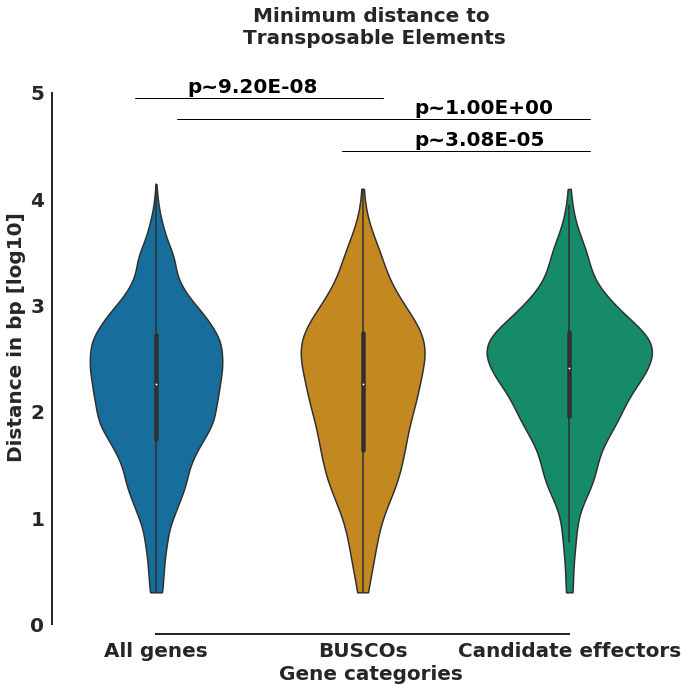

In [53]:
from matplotlib.font_manager import FontProperties
df = TE_dist_df_no_io.iloc[:,[0,1,2]].melt()
sns.set_style("white")
#do a boxplot and swarmplot on the same data
fig, ax = plt.subplots(figsize=(10, 10))

df['log_distance'] = df.value.apply(lambda x: np.log10(x+1))
#ax.set_xscale("log")
sns.violinplot(y='log_distance', x="variable", data=df, cut=0, 
          whis=np.inf, palette=sns.color_palette('colorblind'))
plt.setp(ax.artists, alpha=1)
#sns.swarmplot(y="value", x="variable", data=df,
 #           size=2, color=".3", linewidth=0)
#set the labels
plt.ylim(0, 5.4)

#add the title
font0 = FontProperties()
font = font0.copy()
font.set_weight('bold')
font.set_size(20)

title = 'Minimum distance to Transposable Elements'
plt.title(title.replace('to', 'to\n'), fontproperties=font)

#set font size for labels and such
fs = 20

#fontsize labels
font0 = FontProperties()
font_axis = font0.copy()
font_axis.set_size(20)

plt.xlabel("Gene categories", fontproperties = font_axis)
plt.ylabel('Distance in bp [log10]', fontproperties = font_axis)


#add the stats to it as well with numbers and lines
ax.text(0.15, 5, 'p~%.2E' % corrected_errors[1][0], color='k', fontsize=fs)
ax.plot([-0.1, 1.1], [4.95, 4.95],color ='k' ,lw=1)
ax.text(1.25, 4.8, 'p~%.2E' % corrected_errors[1][1], color='k', fontsize=fs)
ax.plot([0.1, 2.1], [4.75, 4.75],color ='k' ,lw=1)
ax.text(1.25, 4.5, 'p~%.2E' % corrected_errors[1][2], color='k', fontsize=fs)
ax.plot([0.9, 2.1], [4.45, 4.45],color ='k' ,lw=1)
sns.despine(offset=10, trim=True)

#fontsize of ticks
ax.tick_params(labelsize=fs, length=4)
ax.tick_params(width=2)
for axis in ['bottom','left']:
    ax.spines[axis].set_linewidth(2)
for axis in ['top','right']:
    ax.spines[axis].set_linewidth(0)

#save the file as well
outfn = os.path.join(OUTPATH, 'SF6B_genes_to_TEs.tiff')
plt.savefig(outfn, dpi=600,bbox_inches='tight')

In [77]:
df.groupby('variable').describe()

log_distance                      \
                                                 count      mean       std   
variable                                                                     
BUSCOs \n-> All genes subset                     803.0  4.369075  0.636459   
BUSCOs \n-> Candidate effectors                  810.0  4.335362  0.622401   
Candidate effectors \n-> All genes subset        799.0  4.473520  0.600432   
Candidate effectors \n-> BUSCOs                  801.0  4.391379  0.644212   

                                                                         \
                                                min       25%       50%   
variable                                                                  
BUSCOs \n-> All genes subset               1.230449  4.031410  4.474726   
BUSCOs \n-> Candidate effectors            2.513218  3.953385  4.452928   
Candidate effectors \n-> All genes subset  2.579784  4.100990  4.560062   
Candidate effectors \n-> BUSCOs            2.513218  4.008515  4.517301   

                                                               value  \
                                                75%       max  count   
variable                                                               
BUSCOs \n-> All genes subset               4.814070  5.718636  803.0   
BUSCOs \n-> Candidate effectors            4.801340  5.573119  810.0   
Candidate effectors \n-> All genes subset  4.922367  5.630486  799.0   
Candidate effectors \n-> BUSCOs            4.873954  5.556335  801.0   

                                                                              \
                                                   mean           std    min   
variable                                                                       
BUSCOs \n-> All genes subset               50060.663761  62390.203385   17.0   
BUSCOs \n-> Candidate effectors            45740.525926  51504.685908  326.0   
Candidate effectors \n-> All genes subset  59660.779725  64497.364109  380.0   
Candidate effectors \n-> BUSCOs            53536.177278  59306.296883  326.0   

                                                                       \
                                                25%      50%      75%   
variable                                                                
BUSCOs \n-> All genes subset               10750.50  29835.0  65174.0   
BUSCOs \n-> Candidate effectors             8982.25  28374.5  63291.0   
Candidate effectors \n-> All genes subset  12618.00  36313.0  83631.0   
Candidate effectors \n-> BUSCOs            10198.00  32908.0  74809.0   

                                                     
                                                max  
variable                                             
BUSCOs \n-> All genes subset               523162.0  
BUSCOs \n-> Candidate effectors            374213.0  
Candidate effectors \n-> All genes subset  427057.0  
Candidate effectors \n-> BUSCOs            360027.0

This was to look at if subsetting the number of genes to the number of BUSCOs would change the analysis.

Now we are looking if members of the same group are more closley linked than a random subset or groups of equal size

In [144]:
sub_set = len(BedTool(p_effector_bed_fn))

In [145]:
#read in bed files and subset
p_effector_bed = BedTool(p_effector_bed_fn)
p_allgene_bed = BedTool(p_gene_bed_fn)
p_busco_bed = BedTool(p_busco_bed_fn)
p_allall_rand_sub = p_allgene_bed.random_subset(sub_set)
p_effector_bed_rand_sub = p_effector_bed.random_subset(sub_set)
p_busco_bed_rand_sub = p_busco_bed.random_subset(sub_set)

count       810.000000
mean      33815.339506
std       53508.737618
min         579.000000
25%        3180.000000
50%       13415.000000
75%       40234.750000
max      598386.000000
Name: Candidate effectors, dtype: float64


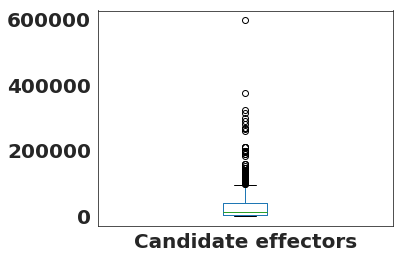

In [146]:
#get the distances with nearest gene effectors vs effectors
p_eself = p_effector_bed_rand_sub.closest(p_effector_bed_rand_sub, d=True,  N=True).to_dataframe().iloc[:,12]
p_eself = p_eself[p_eself > -1].copy()
p_eself.name = 'Candidate effectors'
p_eall = p_effector_bed_rand_sub.closest(p_allall_rand_sub, d=True,  N=True).to_dataframe().iloc[:,12]
p_eall= p_eall[p_eall > -1].copy()
print(p_eself.describe())
p_eself.plot(kind='box')

count       807.000000
mean      45329.513011
std       48351.102485
min          54.000000
25%       11920.000000
50%       32057.000000
75%       64144.500000
max      406502.000000
Name: All_genes, dtype: float64


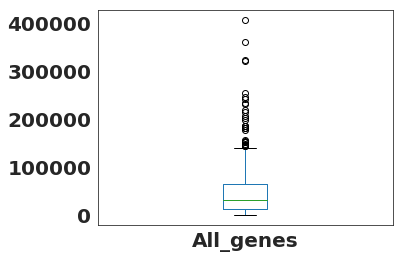

In [147]:
#get the distances with nearest gene all vs all subsampled
p_allall = p_allall_rand_sub.closest(p_allall_rand_sub, d=True, N=True).to_dataframe().iloc[:,12]
p_allall = p_allall[p_allall > -1]
p_allall.name = 'All_genes'
print(p_allall.describe())
p_allall.plot(kind='box')

count       806.000000
mean      41332.859801
std       48884.712941
min          62.000000
25%        9408.750000
50%       24958.000000
75%       57105.000000
max      343027.000000
Name: BUSCO, dtype: float64


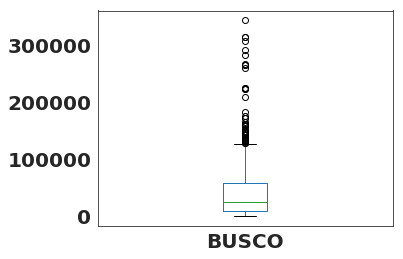

In [148]:
#now with buscos
p_bself = p_busco_bed_rand_sub.closest(p_busco_bed_rand_sub, d=True,  N=True).to_dataframe().iloc[:,12]
p_bself = p_bself[p_bself > -1]
p_bself.name = 'BUSCO'
print(p_bself.describe())
p_bself.plot(kind='box')

count       808.000000
mean      46439.825495
std       50162.379997
min          51.000000
25%       10425.500000
50%       31677.000000
75%       63676.500000
max      347018.000000
Name: No_effectors, dtype: float64


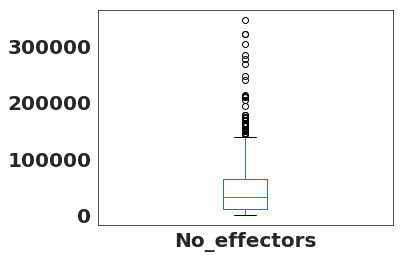

In [149]:
#non_effectors
p_noeffector_bed= BedTool(p_noeffector_bed_fn)
p_noeffector_rand_sub = p_noeffector_bed.random_subset(sub_set)
p_neself = p_noeffector_rand_sub.closest(p_noeffector_rand_sub, d=True,  N=True).to_dataframe().iloc[:,12]
p_neself = p_neself[p_neself > -1]
p_neself.name = 'No_effectors'
print(p_neself.describe())
p_neself.plot(kind='box')

Look if effectors and BUSCOs are actually linked.
The question is if candidate effectors are closer to buscos than to other genes. Do BUSCOs spatially correlate.


effectors distance to closest Busco


count       814.000000
mean      43873.230958
std       51063.698877
min         347.000000
25%        9041.750000
50%       25205.500000
75%       58236.500000
max      314931.000000
Name: Closest Busco to effector, dtype: float64

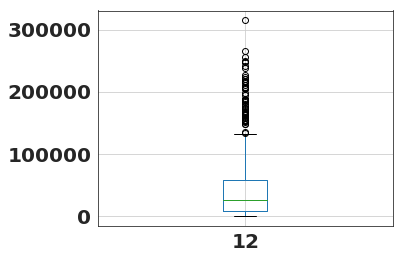

In [150]:
print('effectors distance to closest Busco')
p_effector_bed_rand_sub.closest(p_busco_bed_rand_sub, d=True,t='last', io=True).to_dataframe().boxplot(column=12)
effector_busco_c_df = p_effector_bed_rand_sub.closest(p_busco_bed_rand_sub, d=True,t='last', io=True).to_dataframe().iloc[:,12]
effector_busco_c_df = effector_busco_c_df[effector_busco_c_df>-1]
effector_busco_c_df.name = "Closest Busco to effector"
effector_busco_c_df.describe()

Closest effector to busco


count       800.000000
mean      52072.417500
std       59458.657205
min         347.000000
25%        9513.750000
50%       30606.000000
75%       70545.500000
max      380924.000000
Name: Closest effector to busco, dtype: float64

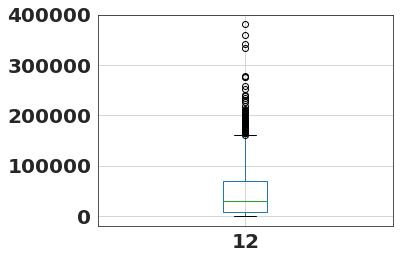

In [151]:
print('Closest effector to busco')
p_busco_bed_rand_sub.closest(p_effector_bed_rand_sub, d=True,t='last', io=True).to_dataframe().boxplot(column=12)
busco_effector_c_df = p_busco_bed_rand_sub.closest(p_effector_bed_rand_sub, d=True,t='last', io=True).to_dataframe().iloc[:,12]
busco_effector_c_df = busco_effector_c_df[busco_effector_c_df>-1]
busco_effector_c_df.name = 'Closest effector to busco'
busco_effector_c_df.describe()

effectors distance to closest rand


count       816.000000
mean      45267.670343
std       48620.575214
min         476.000000
25%       12083.500000
50%       29774.000000
75%       62118.000000
max      327900.000000
Name: Closest randsubset to effector, dtype: float64

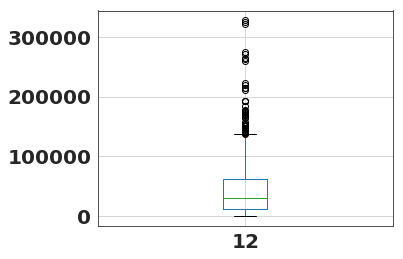

In [152]:
print('effectors distance to closest rand')
p_effector_bed_rand_sub.closest(p_allall_rand_sub, d=True,t='last', io=True).to_dataframe().boxplot(column=12)
effector_randsubset_c_df = p_effector_bed_rand_sub.closest(p_allall_rand_sub, d=True,t='last', io=True).to_dataframe().iloc[:,12]
effector_randsubset_c_df = effector_randsubset_c_df[effector_randsubset_c_df>-1]
effector_randsubset_c_df.name =  "Closest randsubset to effector"
effector_randsubset_c_df.describe()

busco distance to closest rand


count       812.000000
mean      43237.044335
std       46008.457187
min          54.000000
25%       10672.500000
50%       27747.500000
75%       58900.500000
max      346858.000000
Name: Closest rand sub to BUSCO, dtype: float64

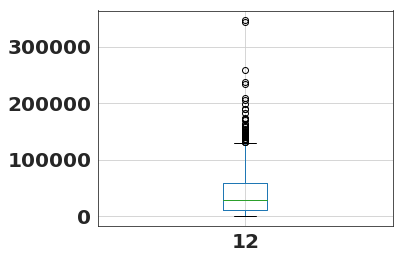

In [153]:
print('busco distance to closest rand')
p_busco_bed_rand_sub.closest(p_allall_rand_sub, d=True,t='last', io=True).to_dataframe().boxplot(column=12)
busco_rand_sub_c_df = p_busco_bed_rand_sub.closest(p_allall_rand_sub, d=True,t='last', io=True).to_dataframe().iloc[:,12]
busco_rand_sub_c_df = busco_rand_sub_c_df[busco_rand_sub_c_df>-1]
busco_rand_sub_c_df.name = "Closest rand sub to BUSCO"
busco_rand_sub_c_df.describe()

rand to closest busco


count       810.000000
mean      46770.756790
std       53080.319463
min          54.000000
25%       10603.750000
50%       29459.500000
75%       61226.250000
max      343027.000000
Name: Closest BUSCO to rand subset, dtype: float64

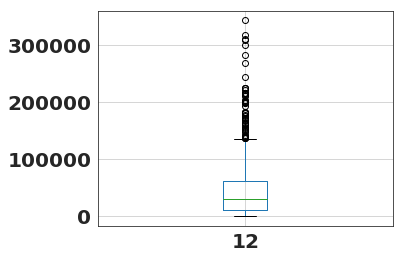

In [154]:
print('rand to closest busco')
p_allall_rand_sub.closest(p_busco_bed_rand_sub, d=True,t='last', io=True).to_dataframe().boxplot(column=12)
rand_sub_busco_c_df = p_allall_rand_sub.closest(p_busco_bed_rand_sub, d=True,t='last', io=True).to_dataframe().iloc[:,12]
rand_sub_busco_c_df = rand_sub_busco_c_df[rand_sub_busco_c_df>-1]
rand_sub_busco_c_df.name = 'Closest BUSCO to rand subset'
rand_sub_busco_c_df.describe()

Rand to closest effector


count       797.000000
mean      54964.922208
std       57779.870293
min         476.000000
25%       13663.000000
50%       35262.000000
75%       75080.000000
max      425530.000000
Name: Closest effector to rand subset, dtype: float64

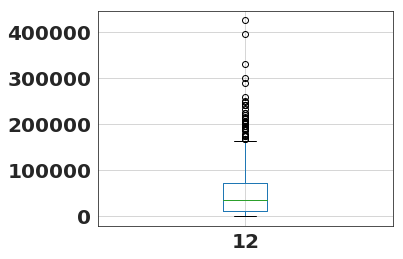

In [155]:
print('Rand to closest effector')
p_allall_rand_sub.closest(p_effector_bed_rand_sub, d=True,t='last', io=True).to_dataframe().boxplot(column=12)
rand_subset_effector_c_df = p_allall_rand_sub.closest(p_effector_bed_rand_sub, d=True,t='last', io=True).to_dataframe().iloc[:,12]
rand_subset_effector_c_df = rand_subset_effector_c_df[rand_subset_effector_c_df>-1]
rand_subset_effector_c_df.name ='Closest effector to rand subset'
rand_subset_effector_c_df.describe()

In [156]:
#all against others both ways to see if effectors are closer to buscos compared to random subset
all_vs_others_c_df = \
 pd.concat([busco_effector_c_df,rand_subset_effector_c_df,effector_busco_c_df,rand_sub_busco_c_df,  \
             effector_randsubset_c_df, busco_rand_sub_c_df ], axis=1)

(array([0, 1, 2, 3, 4, 5]), <a list of 6 Text xticklabel objects>)

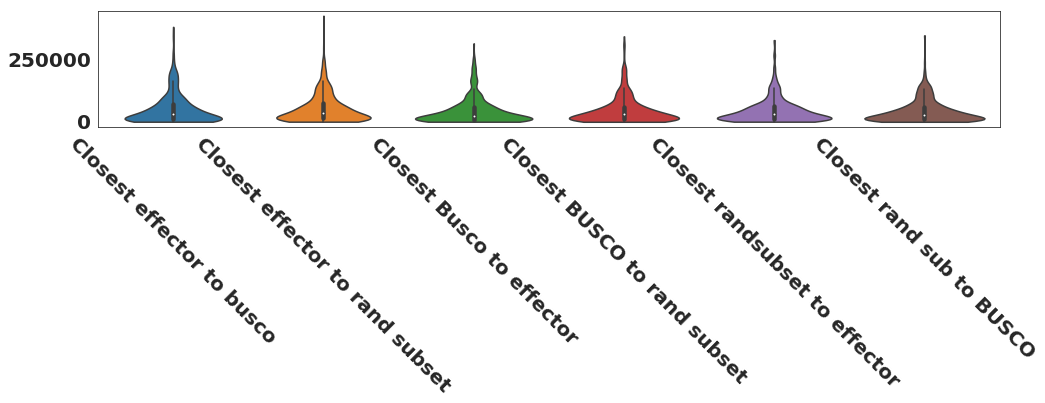

In [157]:
fig, ax = plt.subplots(figsize=(15,6))
sns.violinplot(data=all_vs_others_c_df, cut=0)
plt.xticks(rotation=-45)

(array([0, 1, 2, 3, 4, 5]), <a list of 6 Text xticklabel objects>)

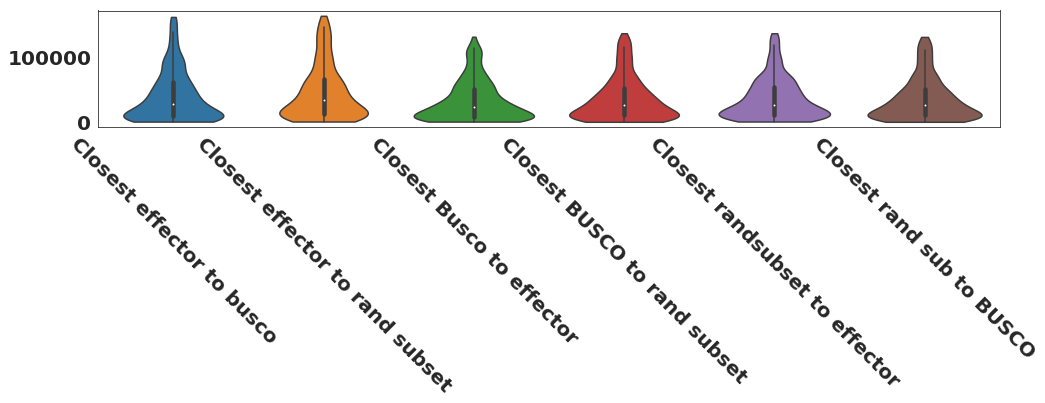

In [158]:
#plot the violine plots for distances once the iqr is present only
all_vs_others_iqr_df = quant_cut_df(all_vs_others_c_df)
fig, ax = plt.subplots(figsize=(15,6))
sns.violinplot(data=all_vs_others_iqr_df, cut=0)
plt.xticks(rotation=-45)
#same as above only normalized for inner quantile residual 

In [159]:
all_vs_others_c_df.describe()

,Closest effector to busco,Closest effector to rand subset,Closest Busco to effector,Closest BUSCO to rand subset,Closest randsubset to effector,Closest rand sub to BUSCO
count,800.000000,797.000000,814.000000,810.000000,816.000000,812.000000
mean,52072.417500,54964.922208,43873.230958,46770.756790,45267.670343,43237.044335
std,59458.657205,57779.870293,51063.698877,53080.319463,48620.575214,46008.457187
min,347.000000,476.000000,347.000000,54.000000,476.000000,54.000000
25%,9513.750000,13663.000000,9041.750000,10603.750000,12083.500000,10672.500000
50%,30606.000000,35262.000000,25205.500000,29459.500000,29774.000000,27747.500000
75%,70545.500000,75080.000000,58236.500000,61226.250000,62118.000000,58900.500000
max,380924.000000,425530.000000,314931.000000,343027.000000,327900.000000,346858.000000


In [160]:
#do some stats on it look first into ranksum test
_, error_e = scipy.stats.ranksums(all_vs_others_c_df['Closest effector to busco'], all_vs_others_c_df['Closest effector to rand subset'])

In [161]:
_, error_b = scipy.stats.ranksums(all_vs_others_c_df['Closest Busco to effector'], all_vs_others_c_df['Closest BUSCO to rand subset'])

In [162]:
#rename figures for paper
new_c_names = ['Candidate effectors \n-> BUSCOs', 'Candidate effectors \n-> All genes subset',\
               'BUSCOs \n-> Candidate effectors',\
               'BUSCOs \n-> All genes subset' ]

In [163]:
all_vs_others_iqr_df.rename(columns=dict(zip(all_vs_others_iqr_df.columns[:4],new_c_names)), inplace=True)

### Supplemental Figure 6D

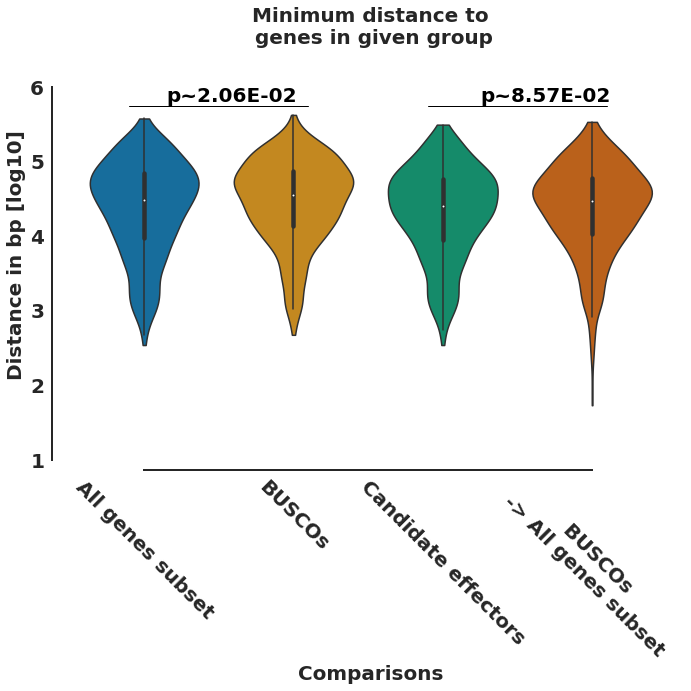

In [174]:
all_vs_others_c_df.rename(columns=dict(zip(all_vs_others_c_df.columns[:4],new_c_names)), inplace=True)
all_vs_others_c_df_melt = all_vs_others_c_df.iloc[:,[0,1,2,3]].melt()

df = all_vs_others_c_df_melt.copy()
df['log_distance'] = df.value.apply(lambda x: np.log10(x))
#do a boxplot and swarmplot on the same data
fig, ax = plt.subplots(figsize=(10, 10))
#ax.set_xscale("log")
sns.violinplot(y='log_distance', x="variable", data=df, cut=0,
          whis=np.inf, palette=sns.color_palette('colorblind'))
plt.setp(ax.artists, alpha=.01)
#sns.swarmplot(y="value", x="variable", data=df,
 #             size=2, color=".3", linewidth=0)
#set the labels
plt.ylim(1, 6.5)
#plt.tight_layout()

#add the title
font0 = FontProperties()
font_axis = font0.copy()
font_axis.set_size(20)

#set font size for labels and such
fs = 20

#add the title and legends
font0 = FontProperties()
font = font0.copy()
font.set_weight('bold')
font.set_size(20)

title = 'Minimum distance to genes in given group'
plt.title(title.replace('to', 'to\n'), fontproperties=font)
plt.xlabel("Comparisons" , fontproperties=font_axis)
plt.ylabel('Distance in bp [log10]', fontproperties=font_axis)

#add the stats to it as well with numbers and lines
ax.text(0.15, 5.8, 'p~%.2E'% error_e, color='k', fontsize=fs)
ax.plot([-0.1, 1.1], [5.75, 5.75],color ='k' ,lw=1)
ax.text(2.25, 5.8, 'p~%.2E'% error_b, color='k', fontsize=fs)
ax.plot([1.9, 3.1], [5.75, 5.75],color ='k' ,lw=1)
sns.despine(offset=10, trim=True)
plt.xticks(rotation=-45)
#save the file as well
#fontsize of ticks
ax.tick_params(labelsize=fs)

#fontsize of ticks
ax.tick_params(labelsize=fs, length=4)
ax.tick_params(width=2)
for axis in ['bottom','left']:
    ax.spines[axis].set_linewidth(2)
for axis in ['top','right']:
    ax.spines[axis].set_linewidth(0)

#save the file as well
outfn = os.path.join(OUTPATH, 'SF6D_genes_to_TEs_v2.tiff')
plt.savefig(outfn, dpi=600,bbox_inches='tight')


Now we look if genes in the same category are associated with each other

In [175]:
_, p_ab = scipy.stats.ranksums(p_allall, p_bself)
_, p_ae = scipy.stats.ranksums(p_allall, p_eself)
_, p_be = scipy.stats.ranksums(p_bself, p_eself)

print(statsmodels.sandbox.stats.multicomp.multipletests([p_ab,p_ae, p_be],\
    alpha=0.05, method='bonferroni', is_sorted=False, returnsorted=False))

(array([ True,  True,  True], dtype=bool), array([  1.02081311e-02,   2.25597379e-19,   9.16030863e-10]), 0.016952427508441503, 0.016666666666666666)


In [176]:
#now make a nearest neightbour dataframe
nn_df = pd.concat([p_allall, p_bself, p_eself], names=['All genes', 'BUSCOs', 'Effectors'], axis=1)

In [177]:
new_c_names = ['All genes subset', "BUSCOs", 'Candidate effectors']
nn_df.rename(columns=dict(zip(nn_df.columns, new_c_names)),inplace=True)

In [178]:
nn_df.describe()

,All genes subset,BUSCOs,Candidate effectors
count,807.000000,806.000000,810.000000
mean,45329.513011,41332.859801,33815.339506
std,48351.102485,48884.712941,53508.737618
min,54.000000,62.000000,579.000000
25%,11920.000000,9408.750000,3180.000000
50%,32057.000000,24958.000000,13415.000000
75%,64144.500000,57105.000000,40234.750000
max,406502.000000,343027.000000,598386.000000


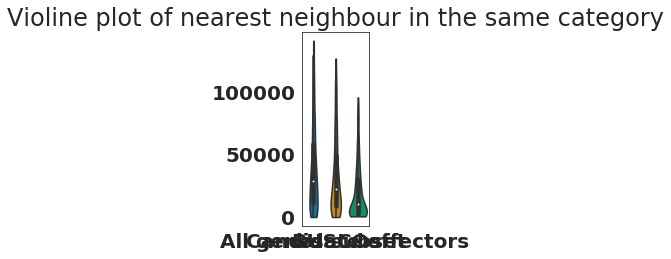

In [179]:
iqr_df_low = nn_df.apply(lambda x: x.quantile(0.25) - 1.5*(x.quantile(0.75) - x.quantile(0.25)) )
iqr_df_low.name ='low'
iqr_df_high = nn_df.apply(lambda x: x.quantile(0.75) + 1.5*(x.quantile(0.75) - x.quantile(0.25)) )
iqr_df_high.name = 'high'

iqr_df = pd.concat([iqr_df_low, iqr_df_high], axis=1).T

iqr_nn_df = nn_df.apply(lambda x: x[(x > iqr_df.loc['low', x.name]) & (x  < iqr_df.loc['high', x.name])], axis=0)
plt.title('Violine plot of nearest neighbour in the same category')
sns.violinplot(data=iqr_nn_df  , palette=sns.color_palette('colorblind'), cut=0)

In [180]:
_, p_ab = scipy.stats.ranksums(p_allall, p_bself)
_, p_ae = scipy.stats.ranksums(p_allall, p_eself)
_, p_be = scipy.stats.ranksums(p_bself, p_eself)

print(statsmodels.sandbox.stats.multicomp.multipletests([p_ab,p_ae, p_be],\
    alpha=0.05, method='bonferroni', is_sorted=False, returnsorted=False))

(array([ True,  True,  True], dtype=bool), array([  1.02081311e-02,   2.25597379e-19,   9.16030863e-10]), 0.016952427508441503, 0.016666666666666666)


In [181]:
corrected_errors_2 = statsmodels.sandbox.stats.multicomp.multipletests([p_ab,p_ae, p_be],\
    alpha=0.05, method='bonferroni', is_sorted=False, returnsorted=False)

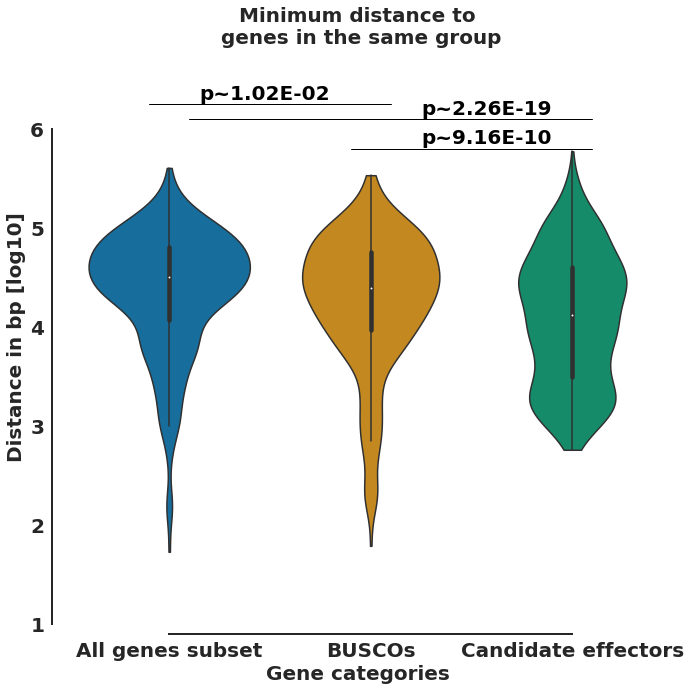

In [182]:
from matplotlib.font_manager import FontProperties
#chanage df here
df = nn_df.melt()
df['log_distance'] = df.value.apply(lambda x: np.log10(x))
#set style
sns.set_style("white")
#do a boxplot and swarmplot on the same data
fig, ax = plt.subplots(figsize=(10, 10))


#ax.set_xscale("log")
sns.violinplot(y='log_distance', x="variable", data=df, cut=0,
          whis=np.inf, palette=sns.color_palette('colorblind'))
plt.setp(ax.artists, alpha=.01)
#sns.swarmplot( data=df,
            #size=2, color=".3", linewidth=0)
#set the labels
plt.ylim(1, 6.8)

#add the title
font0 = FontProperties()
font = font0.copy()
font.set_weight('bold')
font.set_size(20)

#set font size for labels and such
fs = 20
#add the title
font0 = FontProperties()
font_axis = font0.copy()
font_axis.set_size(20)

title = 'Minimum distance to genes in the same group'
plt.title(title.replace('to', 'to\n'), fontproperties=font)
plt.xlabel("Gene categories", fontproperties=font_axis)
plt.ylabel('Distance in bp [log10]', fontproperties=font_axis)
#add the stats to it as well with numbers and lines
ax.text(0.15, 6.3, 'p~%.2E'% corrected_errors_2[1][0], color='k',fontsize=fs)
ax.plot([-0.1, 1.1], [6.25, 6.25],color ='k' ,lw=1)
ax.text(1.25, 6.15, 'p~%.2E'% corrected_errors_2[1][1], color='k',fontsize=fs)
ax.plot([0.1, 2.1], [6.1, 6.1],color ='k' ,lw=1)
ax.text(1.25, 5.85, 'p~%.2E'% corrected_errors_2[1][2], color='k',fontsize=fs)
ax.plot([0.9, 2.1], [5.8, 5.8],color ='k' ,lw=1)
sns.despine(offset=10, trim=True)
sns.set_style("white")
#save the file as well
out_file_name = "_".join(title.split(' '))
#fontsize of ticks
ax.tick_params(labelsize=fs)


#fontsize of ticks
ax.tick_params(labelsize=fs, length=4)
ax.tick_params(width=2)
for axis in ['bottom','left']:
    ax.spines[axis].set_linewidth(2)
for axis in ['top','right']:
    ax.spines[axis].set_linewidth(0)

#save the file as well
outfn = os.path.join(OUTPATH, 'SF6C_genes_groups_on_themself_v2.tiff')
plt.savefig(outfn, dpi=600,bbox_inches='tight')




In [183]:
!wc {p_busco_bed_fn}

 1292  7752 56183 /home/benjamin/genome_assembly/Warrior/DK0911_v04/comp_orthology/DK0911_annotations/DK_0911_v04_p_ctg.busco.gene.bed


In [184]:
df3= _5_to_3_df(p_busco_bed_fn,p_gene_bed_fn )

### Supplemental Figure 6A

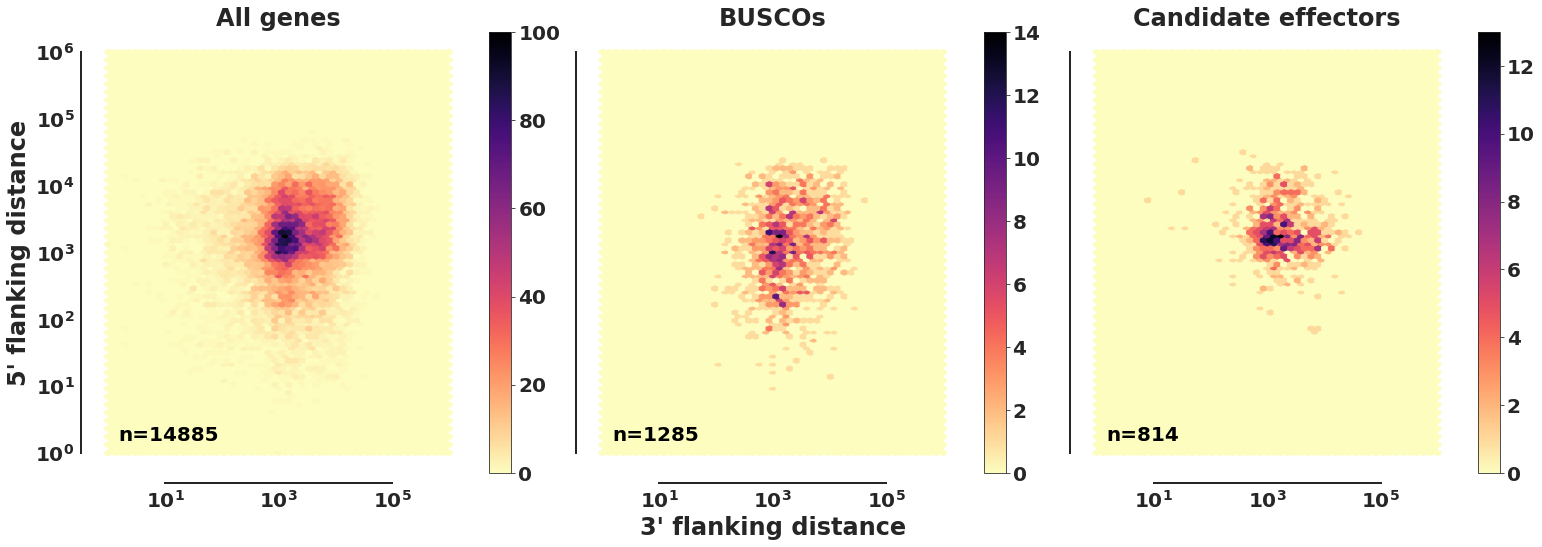

In [192]:
fig, ax = plt.subplots(ncols=3, sharey=True, sharex=True, figsize=(22, 8))

##set font size for labels and such
fs = 20

limit = 500000000000
df = _5_to_3_df(p_gene_bed_fn, p_gene_bed_fn)
df2 = _5_to_3_df( p_effector_bed_fn, p_gene_bed_fn)
df3= _5_to_3_df(p_busco_bed_fn,p_gene_bed_fn )
df = df[(df['3_distance'] < limit) & (df['5_distance'] < limit)].copy()
df2 = df2[(df2['3_distance'] < limit) & (df2['5_distance'] < limit)].copy()
df3 = df3[(df3['3_distance'] < limit) & (df3['5_distance'] < limit)].copy()
hb = ax[0].hexbin(df['3_distance'], df['5_distance'], xscale='log', yscale='log',\
                  gridsize=(50,50)\
        ,  cmap='magma_r',extent=[0, 6, 0, 6])
ax[0].text(1.5, 1.5, 'n=%i'% len(df), color='k',fontsize=fs)
hb1 = ax[2].hexbin(df2['3_distance'], df2['5_distance'],xscale='log', yscale='log',\
                   gridsize=(50,50)\
        ,  cmap='magma_r',extent=[0, 6, 0, 6])
ax[2].text(1.5, 1.5, 'n=%i'% len(df2), color='k',fontsize=fs)
hb2 = ax[1].hexbin(df3['3_distance'], df3['5_distance'], xscale='log', yscale='log',\
                   gridsize=(50,50)\
        ,  cmap='magma_r',extent=[0, 6, 0, 6])
ax[1].text(1.5, 1.5, 'n=%i'% len(df3), color='k',fontsize=fs)
#axis font properties
font0 = FontProperties()
font_axis = font0.copy()
font_axis.set_size(20)



cb = fig.colorbar(hb, ax=ax[0])
cb1 = fig.colorbar(hb1, ax=ax[2])
cb2 = fig.colorbar(hb2, ax=ax[1])

#change the label size of colorbars
cbfs=20
cb.ax.tick_params(labelsize=cbfs)
cb1.ax.tick_params(labelsize=cbfs)
cb2.ax.tick_params(labelsize=cbfs)

# Set common labels
ax[1].set_xlabel("3' flanking distance", fontsize=fs+4,  fontweight = 'bold')
ax[0].set_ylabel("5' flanking distance", fontsize=fs+4, fontweight = 'bold')

#set colorbar labels
sns.despine(offset=10, trim=True)
#cb.set_label('All gene')
#cb1.set_label('Effectors')
#cb2.set_label('BUSCOS')

#set subtitels
fs_title = 24
ax[1].set_title('BUSCOs', fontsize = fs_title, fontweight = 'bold' )
ax[0].set_title('All genes', fontsize = fs_title, fontweight = 'bold' )
ax[2].set_title('Candidate effectors', fontsize = fs_title, fontweight = 'bold' )

#set main title
font0 = FontProperties()
font = font0.copy()
font.set_weight('bold')
font.set_size(20)
title = 'Connectivity hexplots for indicated gene groups'
#plt.suptitle(title, fontproperties=font)

#fontsize of ticks
ax[0].tick_params(labelsize=fs)
ax[1].tick_params(labelsize=fs)
ax[2].tick_params(labelsize=fs)

for pos in range(0,3):
    for axis in ['bottom','left']:
        ax[pos].spines[axis].set_linewidth(2)
    for axis in ['top','right']:
        ax[pos].spines[axis].set_linewidth(0)


outfn = os.path.join(OUTPATH, 'SF6A_intergenic_distances.tiff')
plt.savefig(outfn, dpi=600,bbox_inches='tight')

Done till here for now.

Now this part describes linkage analysis as show in Figure S4 of the current version of the manuscript
The numbers absolutely numbers might change slightly based on the subsampled data set the overall observations are consistent across different subsamples

In [ ]:
max_distance = 12000

In [ ]:
#getting 5' and 3' distance for random subset of effectors
e_to_e_sub_3 = p_effector_bed_rand_sub.closest( p_effector_bed_rand_sub ,  N=True, iu=True, D='a' ).to_dataframe()
e_to_e_sub_3.rename(columns={12:'3_distance', 3:'query', 9:'3_target', 0:'contig'}, inplace=True)
e_to_e_sub_5 = p_effector_bed_rand_sub.closest( p_effector_bed_rand_sub.fn ,  N=True, id=True, D='a' ).to_dataframe()
e_to_e_sub_5.rename(columns={12:'5_distance', 3:'query', 9:'5_target', 0:'contig'}, inplace=True)
distance_effector_df, bin_effector_df = _5_to_3_chains(e_to_e_sub_5,e_to_e_sub_3,max_distance=max_distance, label='Effectors') 

In [ ]:
#now for busco
p_busco_bed_rand_sub_3 = p_busco_bed_rand_sub.closest( p_busco_bed_rand_sub.fn ,  N=True, iu=True, D='a' ).to_dataframe()
p_busco_bed_rand_sub_3.rename(columns={12:'3_distance', 3:'query', 9:'3_target', 0:'contig'}, inplace=True)
p_busco_bed_rand_sub_5 = p_busco_bed_rand_sub.closest( p_busco_bed_rand_sub.fn ,  N=True, id=True, D='a' ).to_dataframe()
p_busco_bed_rand_sub_5.rename(columns={12:'5_distance', 3:'query', 9:'5_target', 0:'contig'}, inplace=True)
distance_busco_df, bin_busco_df = _5_to_3_chains(p_busco_bed_rand_sub_5,p_busco_bed_rand_sub_3,max_distance=max_distance, label='BUSCOs')

In [ ]:
#now for random subest of all genes
all_all_rand_3 = p_allall_rand_sub.closest( p_allall_rand_sub ,  N=True, iu=True, D='a' ).to_dataframe()
all_all_rand_3.rename(columns={12:'3_distance', 3:'query', 9:'3_target', 0:'contig'}, inplace=True)
all_all_rand_5 = p_allall_rand_sub.closest( p_allall_rand_sub.fn ,  N=True, id=True, D='a' ).to_dataframe()
all_all_rand_5.rename(columns={12:'5_distance', 3:'query', 9:'5_target', 0:'contig'}, inplace=True)
distance_all_gene_df, bin_all_gene_df = _5_to_3_chains(all_all_rand_5,all_all_rand_3,max_distance=max_distance, label = 'All genes')

In [ ]:
overall_bining_df = pd.concat([bin_effector_df,bin_busco_df,bin_all_gene_df ])

In [ ]:
sns.color_palette('colorblind', 3)

In [ ]:
#set yourself up for the plots
overall_bining_df['member_count_log'] = np.log2(overall_bining_df.member_count)

conversion_dict = dict(zip(overall_bining_df.label.unique(), range(1,4)))
conversion_dict_color = dict(zip(overall_bining_df.label.unique(), sns.color_palette('colorblind', 3)))

#get the data labels and the color labels
overall_bining_df['number_labels'] = overall_bining_df.label.apply(lambda x: conversion_dict[x])
overall_bining_df['color_labels'] = overall_bining_df.label.apply(lambda x: conversion_dict_color[x])

#set the overall sns style

sns.set_style("white")

#start the figure
fig, ax = plt.subplots(1,1, figsize=(10,4))
title = "Gene clusters with a maximum inter-gene distance of %i" % max_distance
#fill the figure with a scatter plot
ax.scatter(overall_bining_df.bin_size, overall_bining_df.number_labels, s=overall_bining_df.member_count, \
           color =overall_bining_df['color_labels'] )
#set font size 
fs=15

#add the labels
for label, x, y in zip(overall_bining_df.member_count,overall_bining_df.bin_size, overall_bining_df.number_labels ):
    plt.annotate(label, xy =(x+0.2,y),fontsize=fs)
plt.xlabel('Cluster size', fontsize=fs)
ax.set_yticks(range(1,4))
ax.set_yticklabels(overall_bining_df.label.unique())
ax.tick_params(labelsize=fs)

#add the title
font0 = FontProperties()
font = font0.copy()
font.set_weight('bold')
font.set_size(16)
plt.title(title.replace(str(max_distance), '%ikb'%(int(max_distance)/1000))\
          , fontproperties=font, )
ax.title.set_position([0.5,1.05])


sns.despine(offset=10)
out_file_name = "_".join(title.split(' '))
fig.savefig(os.path.join(OUT_FOLDER_FIG, out_file_name+'_v2.png'), dpi=600)

Do the stats by 'hand' as not sure how else. Took over an hour putting this together.
Not sure chi-square is also the best way to calculate this.

In [ ]:
exp = [803,334,117,28,10,0,0]
obs_b =[730,324,162,48,15,6,7]
obs_e = [428,210,96,48,30,0,7]

In [ ]:
_, p_ae = scipy.stats.chisquare(exp, obs_e)
_, p_ab = scipy.stats.chisquare(exp, obs_b)
_, p_eb = scipy.stats.chisquare(obs_e, obs_b)
statsmodels.sandbox.stats.multicomp.multipletests([p_ae, p_ab, p_eb],alpha=0.05, method='bonferroni', is_sorted=False, returnsorted=False)

The next section is concerned with combining the allele data with the candidate effector data to see if anything is going on in terms of allelic vs. singletons

In [ ]:
#Define the PATH
BASE_AA_PATH = '/home/benjamin/genome_assembly/PST79/FALCON/p_assemblies/v9_1/Pst_104E_v12'
BASE_A_PATH = '/home/benjamin/genome_assembly/PST79/FALCON/p_assemblies/v9_1/032017_assembly'
BLAST_RESULT_PATH = os.path.join(BASE_AA_PATH,'allele_analysis' )
ALLELE_PATH =os.path.join(BASE_AA_PATH ,'allele_analysis/alleles_proteinortho_graph516')
ALLELE_QC_PATH = os.path.join(BASE_AA_PATH, 'allele_analysis', \
                              'no_alleles_proteinortho_graph516_QC_Qcov80_PctID70_evalue01')
LIST_PATH = os.path.join(BASE_AA_PATH, 'enrichment_analysis', 'lists')
POST_ALLELE_PATH = os.path.join(BASE_AA_PATH, 'post_allele_analysis')
OUT_PATH = os.path.join(POST_ALLELE_PATH, 'proteinortho_graph516_QC_Qcov80_PctID70_evalue01')
if not os.path.exists(POST_ALLELE_PATH):
    os.mkdir(POST_ALLELE_PATH)
if not os.path.exists(OUT_PATH):
    os.mkdir(OUT_PATH)

In [ ]:
#get all the alleles in as they are not filtered by QCov and PctID but simply taken straight from the 
# proteinortho
allele_header = ['p_gene', 'h_gene']
a_overlap_df = pd.read_csv(os.path.join(ALLELE_PATH, \
                    'Pst_104E_v12_p_ctg.h_contig_overlap.alleles'), sep='\t', header = None,\
                           names=allele_header)
a_overlap_df['Linkage'] = 'h_contig_overlap'
a_no_roverlap_df = pd.read_csv(os.path.join(ALLELE_PATH, \
                    'Pst_104E_v12_p_ctg.no_respective_h_contig_overlap.alleles'), sep='\t', header = None,\
                           names=allele_header)
a_no_roverlap_df['Linkage'] = 'no_r_overlap'
a_no_soverlap_df = pd.read_csv(os.path.join(ALLELE_PATH, \
                    'Pst_104E_v12_p_ctg.no_specific_h_contig_overlap.alleles'), sep='\t', header = None,\
                           names=allele_header)
a_no_soverlap_df['Linkage'] = 'no_s_overlap'
allele_df = pd.concat([a_overlap_df, a_no_roverlap_df,a_no_soverlap_df ], axis=0)

In [ ]:
#get the blast dataframe and the QC dataframe
allele_blast_df = pd.read_csv(os.path.join(BLAST_RESULT_PATH, 'Pst_104E_v12_p_ctg.Pst_104E_v12_h_ctg.0.001.blastp.outfmt6.allele_analysis'), sep='\t')
allele_QC_df = pd.read_csv(os.path.join(ALLELE_QC_PATH, 'Pst_104E_v12_ph_ctg.no_alleles_QC.Qcov80.PctID70.df'), sep='\t')
allele_QC_df = allele_QC_df[~((allele_QC_df.Query.isin(allele_df.p_gene))|(allele_QC_df.Query.isin(allele_df.h_gene)))]
#quick check if all the numbers of genes add up
len(allele_df.p_gene.unique())+ len(allele_df.h_gene.unique())+len(allele_QC_df.Query.unique()) == 30249

In [ ]:
#make a new column linking stuff together
allele_blast_df['match'] = allele_blast_df.Query + allele_blast_df.Target
allele_df['match'] = allele_df.p_gene + allele_df.h_gene

In [ ]:
allele_hits_only_df = allele_blast_df[(allele_blast_df.match.isin(allele_df.match))].copy()

In [ ]:
#get the PctID fo the allele blast hits primary contigs onto haplotig gene models
effecter_bpctid = allele_hits_only_df[(allele_hits_only_df.Query.isin(p_effector_list))]['PctID'].tolist()

In [ ]:
noeffecter_bpctid = allele_hits_only_df[~(allele_hits_only_df.Query.isin(p_effector_list))]\
['PctID'].tolist()

In [ ]:
busco_bpctid = allele_hits_only_df[(allele_hits_only_df.Query.isin(p_busco_list))]['PctID'].tolist()

In [ ]:
non_busco_list = pd.read_csv(p_non_busco_list_fn, sep='\t', header =None)[0].tolist()
non_be_list = pd.read_csv(p_noeffectorp_nobusco_bed_fn, sep='\t', header =None)[3].str.replace('TU', 'model').tolist()

In [ ]:
non_busco_bpctid = allele_hits_only_df[(allele_hits_only_df.Query.isin(non_busco_list))]['PctID'].tolist()
non_be_list_bpctid = allele_hits_only_df[(allele_hits_only_df.Query.isin(non_be_list))]['PctID'].tolist()

In [ ]:
#bind all the blast percentage IDs together
bpctid_df = pd.concat([pd.Series(effecter_bpctid),pd.Series(noeffecter_bpctid)\
                          , pd.Series(busco_bpctid), pd.Series(non_busco_bpctid)\
                      ,pd.Series(non_be_list_bpctid)], axis=1)
bpctid_df.rename(columns={0: 'effector', 1:'no_effector', 2: 'buscos', 3: 'non_buscos',\
                         4:'no_be'}, inplace=True)
bpctid_df.describe()

In [ ]:
bpctid_melt_df = bpctid_df.melt()

In [ ]:
#a quick plot of the distributions of blast pct id of allele pairs in different categories
f, ax = plt.subplots(figsize=(15, 10))
#ax.set_xscale("log")
sns.violinplot(x="value", y="variable", data=bpctid_melt_df, cut=0,
          whis=np.inf, saturation=0.5)
plt.setp(ax.artists, alpha=.01)
#sns.swarmplot(x="value", y="variable", data=bpctid_melt_df,
  #            size=2, color=".3", linewidth=0)

In [ ]:
#quick non-parametric test comparing the different pctid distributions in different categories
stats.mstats.kruskalwallis([float(x) for x in bpctid_df.effector.dropna()]\
                           ,[float(x) for x in bpctid_df.no_be.dropna()],\
                          [float(x) for x in bpctid_df.buscos.dropna()])

Do some analysis on windows. Make 30kb windows and 100kb windows sliding by 1000bp
Then caculate the GC content, BUSCO content, EFFECTOR content, Gene content, secreted proteins, haustoria expressed proteins and plot this all out.


I only used the calcuated windows to make the Circa plot. Overwise this part is not really part of the manuscript itself yet supports some of the hypotheses broad forward and brings some additional insight likely included in future publications. I leave it here for illustratin purposes for now.



In [ ]:
W_PATH = os.path.join(OUT_FOLDER, 'window_analysis')
if not os.path.exists(W_PATH):
    os.mkdir(W_PATH)

In [ ]:
#make some windows beds
window_fn_dict = {}
window_bed_dict = {}
window_fn_dict['w30kb_s1kb'] = os.path.join(W_PATH, 'Pst_104E_v12_p_ctg.w30.s1.bed')
window_fn_dict['w100kb_s1kb'] = os.path.join(W_PATH, 'Pst_104E_v12_p_ctg.w100.s1.bed')
window_fn_dict['w30kb'] = os.path.join(W_PATH, 'Pst_104E_v12_p_ctg.w30.bed')
window_fn_dict['w100kb'] = os.path.join(W_PATH, 'Pst_104E_v12_p_ctg.w100.bed')
genome_size_f_fn = os.path.join(W_PATH, 'Pst_104E_v12_p_ctg.genome_file')
contig_fn = os.path.join(GFF_FOLDER,'Pst_104E_v12_p_ctg.fa' )
os.chdir(W_PATH)
#now make the window files
!bedtools makewindows -g {genome_size_f_fn} -w 100000 -s 1000 > {window_fn_dict['w100kb_s1kb']}
!bedtools makewindows -g {genome_size_f_fn} -w 30000 -s 1000 > {window_fn_dict['w30kb_s1kb']}
!bedtools makewindows -g {genome_size_f_fn} -w 100000 > {window_fn_dict['w100kb']}
!bedtools makewindows -g {genome_size_f_fn} -w 30000 > {window_fn_dict['w30kb']}

In [ ]:
#new make a bedtools window dataframe
for key, value in window_fn_dict.items() :
    window_bed_dict[key] = BedTool(value)

In [ ]:
#now make an AT bed df dict and save it out
window_AT_dict = {}
for key, value in window_bed_dict.items():
    tmp_df = value.nucleotide_content(fi=contig_fn).to_dataframe().iloc[1:,[0,1,2, 3]]
    tmp_df.rename(columns={'name':'%AT'}, inplace=True)
    tmp_fn = window_fn_dict[key].replace('bed', 'AT.bed')
    tmp_df.to_csv(tmp_fn, header=None, sep='\t', index=None)
    tmp_fn = window_fn_dict[key].replace('bed', 'AT.circabed')
    tmp_df.to_csv(tmp_fn, sep='\t', index=None)
    window_AT_dict[key] = tmp_df
    tmp_df = ''

In [ ]:
feature_fn_dict = {}
feature_fn_dict['genes'] = os.path.join(LIST_PATH, 'Pst_104E_v12_p_all.gene.bed' )
feature_fn_dict['effector'] = os.path.join(LIST_PATH, 'Pst_104E_v12_p_effector.gene.bed' )
feature_fn_dict['busco'] = os.path.join(LIST_PATH, 'Pst_104E_v12_p_busco.gene.bed' )
feature_fn_dict['haustoria'] = os.path.join(LIST_PATH, 'Pst_104E_v12_cluster_8.gene.bed' )
feature_fn_dict['no_be'] = os.path.join(LIST_PATH, 'Pst_104E_v12_p_non_busco_non_effector.gene.bed')
feature_fn_dict['no_effector'] =os.path.join(LIST_PATH, 'Pst_104E_v12_p_noeffector.gene.bed')
feature_fn_dict['no_busco'] = os.path.join(LIST_PATH, 'Pst_104E_v12_p_non_busco.gene.bed')
feature_fn_dict['TE_g400'] = os.path.join(LIST_PATH,\
                                'Pst_104E_v12_p_ctg.REPET.sorted.g400_superfamily.bed' )
feature_fn_dict['TE_g1000'] = os.path.join(LIST_PATH,\
                                'Pst_104E_v12_p_ctg.REPET.sorted.g1000_superfamily.bed' )
feature_fn_dict['TE_g0'] = os.path.join(LIST_PATH,\
                                'Pst_104E_v12_p_ctg.REPET.sorted.superfamily.bed' )

In [ ]:
feature_bed_dict = {}
for key, value in feature_fn_dict.items():
    feature_bed_dict[key] = BedTool(value)

In [ ]:
feature_overlap_df_dict = {}
for wkey, wbed in window_bed_dict.items():
    for fkey, fbed in feature_bed_dict.items():
        tmp_df = wbed.coverage(fbed, F=0.1).to_dataframe().iloc[:,[0,1,2,3,6]]
        tmp_df.rename(columns={'name': 'overlap_count', 'thickStart': 'overlap_fraction'}, inplace=True)
        tmp_fn = feature_fn_dict[fkey].replace('bed', '%s.overlap.bed' % wkey)
        feature_overlap_df_dict[tmp_fn.split('/')[-1]] = tmp_df
        tmp_df.to_csv(tmp_fn, sep='\t', header=None, index=None)
        tmp_fn = feature_fn_dict[fkey].replace('bed', '%s.overlap.circabed' % wkey)
        tmp_df.to_csv(tmp_fn, sep='\t', index=None)
        
#tmp_bed.intersect(feature_bed_dict[key], c=True, F=0.1).to_dataframe() 

In [ ]:
stats.stats.spearmanr(feature_overlap_df_dict['Pst_104E_v12_p_effector.gene.w30kb_s1kb.overlap.bed'].overlap_fraction,\
                    feature_overlap_df_dict['Pst_104E_v12_p_ctg.REPET.sorted.superfamily.w30kb_s1kb.overlap.bed'].overlap_fraction)

In [ ]:
stats.stats.spearmanr(feature_overlap_df_dict['Pst_104E_v12_p_all.gene.w30kb_s1kb.overlap.bed'].overlap_fraction,\
                    feature_overlap_df_dict['Pst_104E_v12_p_ctg.REPET.sorted.superfamily.w30kb_s1kb.overlap.bed'].overlap_fraction)

In [ ]:
stats.stats.spearmanr(feature_overlap_df_dict['Pst_104E_v12_p_busco.gene.w30kb_s1kb.overlap.bed'].overlap_fraction,\
                    feature_overlap_df_dict['Pst_104E_v12_p_ctg.REPET.sorted.superfamily.w30kb_s1kb.overlap.bed'].overlap_fraction)

In [ ]:
stats.stats.spearmanr(feature_overlap_df_dict['Pst_104E_v12_p_non_busco_non_effector.gene.w30kb_s1kb.overlap.bed'].overlap_fraction,\
                    feature_overlap_df_dict['Pst_104E_v12_p_ctg.REPET.sorted.superfamily.w30kb_s1kb.overlap.bed'].overlap_fraction)

It is an interesting observation that the window approach of TEs vs. other features shows the least negative correlation for candidate effectors. This might suggest there is actually a correlation between effectors and TEs.

Now look into the correlations of count and TEs

In [ ]:
stats.stats.spearmanr(feature_overlap_df_dict['Pst_104E_v12_p_effector.gene.w30kb_s1kb.overlap.bed'].overlap_count,\
                    feature_overlap_df_dict['Pst_104E_v12_p_ctg.REPET.sorted.superfamily.w30kb_s1kb.overlap.bed'].overlap_count)

In [ ]:
stats.stats.spearmanr(feature_overlap_df_dict['Pst_104E_v12_p_all.gene.w30kb_s1kb.overlap.bed'].overlap_count,\
                    feature_overlap_df_dict['Pst_104E_v12_p_ctg.REPET.sorted.superfamily.w30kb_s1kb.overlap.bed'].overlap_count)

In [ ]:
stats.stats.spearmanr(feature_overlap_df_dict['Pst_104E_v12_p_busco.gene.w30kb_s1kb.overlap.bed'].overlap_count,\
                    feature_overlap_df_dict['Pst_104E_v12_p_ctg.REPET.sorted.superfamily.w30kb_s1kb.overlap.bed'].overlap_count)

In [ ]:
stats.stats.spearmanr(feature_overlap_df_dict['Pst_104E_v12_p_non_busco_non_effector.gene.w30kb_s1kb.overlap.bed'].overlap_count,\
                    feature_overlap_df_dict['Pst_104E_v12_p_ctg.REPET.sorted.superfamily.w30kb_s1kb.overlap.bed'].overlap_count)

Now look at the correlaction of %AT and gene content

In [ ]:
stats.stats.spearmanr(feature_overlap_df_dict['Pst_104E_v12_p_non_busco_non_effector.gene.w30kb_s1kb.overlap.bed'].overlap_fraction\
 ,[1-np.float(x) for x in window_AT_dict['w30kb_s1kb']['%AT']])

In [ ]:
stats.stats.spearmanr(feature_overlap_df_dict['Pst_104E_v12_p_busco.gene.w30kb_s1kb.overlap.bed'].overlap_fraction\
 ,[1-np.float(x) for x in window_AT_dict['w30kb_s1kb']['%AT']])

In [ ]:
stats.stats.spearmanr(feature_overlap_df_dict['Pst_104E_v12_p_effector.gene.w30kb_s1kb.overlap.bed'].overlap_fraction\
 ,[1-np.float(x) for x in window_AT_dict['w30kb_s1kb']['%AT']])

In [ ]:
stats.stats.spearmanr(feature_overlap_df_dict['Pst_104E_v12_p_all.gene.w30kb_s1kb.overlap.bed'].overlap_fraction\
 ,[1-np.float(x) for x in window_AT_dict['w30kb_s1kb']['%AT']])

In [ ]:
#this idea is based on the Genome Sequence of S. sclerotiorum in GBE to test if effectors
#are in gene spares region in the sense of non-effectors vs. effectors and not
#neccessarily nearest neighours
#this is consistent with the idea that candidate effectors cluster with each other and
#this clustering drives the gene hexbin plot
#seems to be only visible for certain window sizes.
#too big a window might dilute the signal
x_now = [np.log10(x/y) for x,y in\
   zip(feature_overlap_df_dict['Pst_104E_v12_p_effector.gene.w30kb_s1kb.overlap.bed'].overlap_fraction,\
       feature_overlap_df_dict['Pst_104E_v12_p_noeffector.gene.w30kb_s1kb.overlap.bed'].overlap_fraction)]
y_now=[np.log10(x) for x in feature_overlap_df_dict['Pst_104E_v12_p_all.gene.w30kb_s1kb.overlap.bed'].overlap_fraction]  
fig, ax = plt.subplots(figsize=(12,12))
plt.scatter(x=x_now,y=y_now, marker ='+', color='k', alpha=0.3)
print(stats.stats.spearmanr(x_now, y_now,nan_policy='omit'))

In [ ]:
#this idea is based on the Genome Sequence of S. sclerotiorum in GBE to test if effectors
#are in gene spares region in the sense of non-effectors vs. effectors and not
#neccessarily nearest neighours
x_now = [np.log10(x/y) for x,y in\
   zip(feature_overlap_df_dict['Pst_104E_v12_p_effector.gene.w100kb_s1kb.overlap.bed'].overlap_fraction,\
       feature_overlap_df_dict['Pst_104E_v12_p_noeffector.gene.w100kb_s1kb.overlap.bed'].overlap_fraction)]
y_now=[np.log10(x) for x in feature_overlap_df_dict['Pst_104E_v12_p_all.gene.w100kb_s1kb.overlap.bed'].overlap_fraction]  
fig, ax = plt.subplots(figsize=(12,12))
plt.scatter(x=x_now,y=y_now, marker ='+', color='k', alpha=0.3)
print(stats.stats.spearmanr(x_now, y_now,nan_policy='omit'))

In [ ]:
#busco follow the same pattern again this might be linked to the clustering of BUSCOs with
#each other
x_now = [np.log10(x/y) for x,y in\
   zip(feature_overlap_df_dict['Pst_104E_v12_p_busco.gene.w30kb_s1kb.overlap.bed'].overlap_fraction,\
       feature_overlap_df_dict['Pst_104E_v12_p_non_busco.gene.w30kb_s1kb.overlap.bed'].overlap_fraction)]
y_now=[np.log10(x) for x in feature_overlap_df_dict['Pst_104E_v12_p_all.gene.w30kb_s1kb.overlap.bed'].overlap_fraction]  
fig, ax = plt.subplots(figsize=(12,12))
plt.scatter(x=x_now,y=y_now, marker ='+', color='k', alpha=0.3)
#sns.regplot(x=np.array(x_now),y=np.array(y_now), marker ='+', color='k')
print(stats.stats.spearmanr(x_now, y_now, nan_policy='omit'))

In [ ]:
x_now = [np.log10(x/y) for x,y in\
   zip(feature_overlap_df_dict['Pst_104E_v12_p_busco.gene.w30kb_s1kb.overlap.bed'].overlap_fraction,\
       feature_overlap_df_dict['Pst_104E_v12_p_non_busco.gene.w30kb_s1kb.overlap.bed'].overlap_fraction)]
y_now=[np.log10(x) for x in feature_overlap_df_dict['Pst_104E_v12_p_all.gene.w30kb_s1kb.overlap.bed'].overlap_fraction]  
fig, ax = plt.subplots(figsize=(12,12))
plt.scatter(x=x_now,y=y_now, marker ='+', color='k')
#sns.regplot(x=np.array(x_now),y=np.array(y_now), marker ='+', color='k')
print(stats.stats.spearmanr(x_now, y_now, nan_policy='omit'))

In [ ]:
#unclear for this part of the effect would need to look more into it
x_now=[np.log10((x+y)/z) for x,y,z in\
   zip(feature_overlap_df_dict['Pst_104E_v12_p_effector.gene.w30kb_s1kb.overlap.bed'].overlap_fraction,\
       feature_overlap_df_dict['Pst_104E_v12_p_busco.gene.w30kb_s1kb.overlap.bed'].overlap_fraction,\
       feature_overlap_df_dict['Pst_104E_v12_p_non_busco_non_effector.gene.w30kb_s1kb.overlap.bed'].overlap_fraction)]
y_now=[np.log10(x) for x in feature_overlap_df_dict['Pst_104E_v12_p_all.gene.w30kb_s1kb.overlap.bed'].overlap_fraction]
fig, ax = plt.subplots(figsize=(12,12))
plt.scatter(x=x_now,y=y_now, marker ='+', color='k', alpha =0.1)
#sns.regplot(x=np.array(x_now),y=np.array(y_now), marker ='+', color='k')
print(stats.stats.spearmanr(x_now, y_now, nan_policy='omit'))